In [1]:
import os
from pprint import pprint
import time
import numpy as np
# from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import img2pdf
import plotly.express as px
import seaborn as sns

print("Importing torch ...")
begin = time.time()
import torch
print("Imported torch in {:.2f} seconds".format(time.time() - begin))

import logging
logging.basicConfig(level=logging.WARNING)

from data.turtle_data_loading import get_file_paths, TurtleDataset

Importing torch ...
Imported torch in 8.96 seconds
Using new version 2 of turtle_data_generate.py


In [2]:
default_device = "cuda"
torch.set_default_device(default_device)

In [3]:
from turtle_id_test_config import data_path

from turtle_id_test_config import test_scalar_reg_path, test_reg_map_path

from turtle_id_test_config import data_path, upper_level
import turtle_id_test_config

# data_group = "train"
data_group = "test"

# https://wandb.ai/wof/turtle_id_2022/runs/cfbkuz9y
model_date, epoch = "06_24_19_56_05", 50

test_reg_map_results_path = f"{test_reg_map_path}/{model_date}-{epoch}/{data_group}"

model_path=f"{upper_level}/models/model-turtle_id_2022-2024_{model_date}/model_epoch_{epoch}.pt"

In [4]:
num_samples = 1 # 0 for all
size = 256
# size = 512
sigmas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
# sigmas = [0.05]

In [5]:
# file_paths:dict = get_file_paths(data_path, "test", num_samples, sigmas, size)
file_paths:dict = {
    0: ['images_crop_resize_256_greyscale/t008/PaXakrkxqN.JPG'],
    0.05: ['images_crop_resize_256_greyscale_noisy_0_05/t008/PaXakrkxqN.JPG'],
    0.1: ['images_crop_resize_256_greyscale_noisy_0_1/t008/PaXakrkxqN.JPG'],
    0.15: ['images_crop_resize_256_greyscale_noisy_0_15/t008/PaXakrkxqN.JPG'],
    0.2: ['images_crop_resize_256_greyscale_noisy_0_2/t008/PaXakrkxqN.JPG'],
    0.25: ['images_crop_resize_256_greyscale_noisy_0_25/t008/PaXakrkxqN.JPG'],
    0.3: ['images_crop_resize_256_greyscale_noisy_0_3/t008/PaXakrkxqN.JPG'],
}

In [6]:
# pprint(file_paths)

In [7]:
# file_paths is a dict with keys the sigmas and values the list of file paths
# Check that every list has the same length
for key in file_paths.keys():
    assert len(file_paths[key]) == num_samples

In [8]:
# test_dataset = TurtleDataset(data_path, file_paths, default_device)

In [9]:
# assert len(test_dataset) == num_samples * len(sigmas), f"len(test_dataset)={len(test_dataset)} != {num_samples} * {len(sigmas)}"

In [10]:
def apply_to_files(func):
    results = []
    for sigma in tqdm(sigmas):
        print(f"sigma={sigma}")
        for sample_id in tqdm(range(num_samples), 
                            #   leave=False # remove inner progress bar upon completion (as in "don't leave it there")
                              ):
            file = file_paths[sigma][sample_id]
            extension = file.split(".")[-1]
            file = file.replace(f".{extension}", "")
            res = func(file)
            if res is not None:
                results.append(res)
    return results
            

In [11]:
def get_best_scalar_reg_result(file:str):
    scalar_reg_path = f"{test_scalar_reg_path}/{file}"
    reg_map_path = f"{test_reg_map_results_path}/{file}"
    reg_map_path_for_scalar_reg = f"{reg_map_path}/scalar"
    os.makedirs(reg_map_path_for_scalar_reg, exist_ok=True)
    
    # Read csv containing results for the current sample using scalar regularization parameter lambda
    results_csv = f"{scalar_reg_path}/results.csv"
    df = pd.read_csv(results_csv)
    # Assert there are 81 rows for 81 values of lambda from 0 to 0.4
    assert len(df) == 81, f"len(df)={len(df)} != 81"
    
    def get_best_metric(metric:str):
        best = df[metric].max()
        row = df[df[metric] == best].iloc[0]
        _lambda = row["lambda"]
        lambda_str = f"{_lambda:.3f}".replace(".", "_")
        in_file_name = f"{scalar_reg_path}/lambda_{lambda_str}"
        in_png_file = f"{in_file_name}.PNG"
        in_pdf_file = f"{in_file_name}.pdf"
        
        out_file_name = f"{reg_map_path_for_scalar_reg}/best_{metric}"
        out_png_file = f"{out_file_name}.png"
        out_pdf_file = f"{out_file_name}.pdf"
        
        # Copy file from in to out
        os.system(f"cp {in_png_file} {out_png_file}")
        os.system(f"cp {in_pdf_file} {out_pdf_file}")
        row_df = pd.DataFrame([row])
        row_df.to_csv(f"{out_file_name}.csv", index=False)
        
    get_best_metric("PSNR")
    get_best_metric("SSIM")

In [12]:
apply_to_files(get_best_scalar_reg_result)

  0%|          | 0/6 [00:00<?, ?it/s]

sigma=0.05


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.1


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.15


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.2


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.25


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.3


  0%|          | 0/1 [00:00<?, ?it/s]

[]

In [13]:
def compute_metrics_diff(file:str):
    reg_map_path = f"{test_reg_map_results_path}/{file}"
    reg_map_path_for_scalar_reg = f"{reg_map_path}/scalar"
    
    # Read csv for reg map results
    reg_map_csv = f"{reg_map_path}/metrics.csv"
    df_reg_map = pd.read_csv(reg_map_csv)
    
    # Read csv for scalar reg results. There best_PSNR and best_SSIM
    scalar_reg_psnr_csv = f"{reg_map_path_for_scalar_reg}/best_PSNR.csv"
    scalar_reg_ssim_csv = f"{reg_map_path_for_scalar_reg}/best_SSIM.csv"
    df_scalar_reg_psnr = pd.read_csv(scalar_reg_psnr_csv)
    df_scalar_reg_ssim = pd.read_csv(scalar_reg_ssim_csv)
    
    # Get diff
    diff_psnr = df_reg_map["PSNR"] - df_scalar_reg_psnr["PSNR"]
    diff_ssim = df_reg_map["SSIM"] - df_scalar_reg_ssim["SSIM"]
    
    # Save diff
    diff_csv = f"{reg_map_path}/diff.csv"
    diff_df = pd.DataFrame({"diff_PSNR": diff_psnr, "diff_SSIM": diff_ssim})
    diff_df.to_csv(diff_csv, index=False)

In [14]:
apply_to_files(compute_metrics_diff)

  0%|          | 0/6 [00:00<?, ?it/s]

sigma=0.05


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.1


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.15


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.2


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.25


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.3


  0%|          | 0/1 [00:00<?, ?it/s]

[]

In [15]:
def read_diff(file:str):
    reg_map_path = f"{test_reg_map_results_path}/{file}"
    diff_csv = f"{reg_map_path}/diff.csv"
    df = pd.read_csv(diff_csv)
    assert len(df) == 1
    return (df["diff_PSNR"], df["diff_SSIM"])

In [16]:
def get_diffs():
    diffs = apply_to_files(read_diff)
    diffs = np.array(diffs)
    diffs_psnr = diffs[:, 0]
    diffs_ssim = diffs[:, 1]
    return diffs_psnr, diffs_ssim

In [17]:
diffs_psnr, diffs_ssim = get_diffs()

  0%|          | 0/6 [00:00<?, ?it/s]

sigma=0.05


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.1


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.15


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.2


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.25


  0%|          | 0/1 [00:00<?, ?it/s]

sigma=0.3


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
def plot_diffs(diffs, metric:str):
    # fig = px.histogram(diffs, title=f"Distribution of {metric} differences")
    # fig.show()
    
    plt.figure(figsize=(6, 4))
    
    # plt.hist(diffs, bins=50)
    
    sns.histplot(diffs, bins=50, legend=False)

    plt.title(f"Distribution of {metric} differences")
    plt.show();

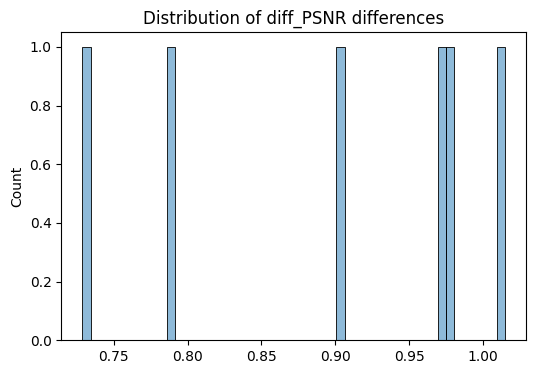

In [19]:
plot_diffs(diffs_psnr, "diff_PSNR")

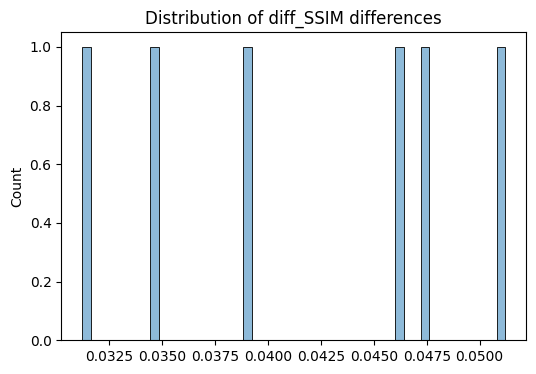

In [20]:
plot_diffs(diffs_ssim, "diff_SSIM")

In [21]:
def get_examples():
    max_diff_psnr = np.argmax(diffs_psnr)
    max_diff_ssim = np.argmax(diffs_ssim)
        
    min_diff_psnr = np.argmin(diffs_psnr)
    min_diff_ssim = np.argmin(diffs_ssim)

    print(f"max_diff_psnr={max_diff_psnr}, max_diff_ssim={max_diff_ssim}, min_diff_psnr={min_diff_psnr}, min_diff_ssim={min_diff_ssim}")
    
    assert max_diff_psnr != max_diff_ssim
    assert min_diff_psnr != min_diff_ssim    

In [22]:
get_examples()

max_diff_psnr=1, max_diff_ssim=2, min_diff_psnr=5, min_diff_ssim=0


In [23]:
# # Fix some values
# good_psnr = 200
# good_ssim = 343
# bad = 44
# first = 0

good_psnr = 0
good_ssim = 41
bad = 95

In [24]:
def get_file_name(idx:int):
    sigma_idx = idx % len(sigmas)
    sigma = sigmas[sigma_idx]
    sample_id = idx // len(sigmas)
    file = file_paths[sigma][sample_id]
    return file

In [25]:
example_file = get_file_name(good_psnr)

In [26]:
print(f"example_file={example_file}")

example_file=images_crop_resize_256_greyscale_noisy_0_05/t008/PaXakrkxqN.JPG


In [27]:
good_psnr_sample_id = good_psnr // num_samples